# Spatial Queries

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline  

In [4]:
census_tracts = gpd.read_file("zip://../data/census/Tracts/cb_2013_06_tract_500k.zip")
census_tracts_ac = census_tracts.loc[census_tracts['COUNTYFP'] == '001'].reset_index(drop=True)

---

### Challenge 1: Spatial Relationship Query

Let's use a spatial relationship query to create a new dataset containing Berkeley schools!

Run the next two cells to load datasets containing Berkeley's city boundary and Alameda County's
schools and to reproject them to EPSG: 26910.

Then in the following cell, write your own code to:

1. Subset the schools for only those `within` Berkeley.
2. Plot the Berkeley boundary and then the schools as an overlay map.

---

In [5]:
# Load the Berkeley boundary
berkeley = gpd.read_file("../data/berkeley/BerkeleyCityLimits.shp")
# Transform to EPSG:26910
berkeley_utm10 = berkeley.to_crs("epsg:26910")
# Look at GeoDataFrame
berkeley_utm10.head()

,CNTY_FIPS,geometry
0,001,"POLYGON ((564128.016 4195462.498, 564144.135 4..."


In [6]:
# Load the Alameda County schools CSV
schools_df = pd.read_csv('../data/alco_schools.csv')
# Convert it to a GeoDataFrame
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
# Define its unprojected (EPSG:4326) CRS
schools_gdf.crs = "epsg:4326"
# Transform to EPSG:26910
schools_gdf_utm10 = schools_gdf.to_crs("epsg:26910")
# Look at GeoDataFrame
schools_df.head()

,X,Y,Site,Address,City,State,Type,API,Org,geometry
0,-122.238761,37.744764,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public,POINT (-122.23876 37.74476)
1,-122.251856,37.738999,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public,POINT (-122.25186 37.73900)
2,-122.258915,37.762058,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public,POINT (-122.25892 37.76206)
3,-122.234841,37.765250,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public,POINT (-122.23484 37.76525)
4,-122.238078,37.753964,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public,POINT (-122.23808 37.75396)


In [7]:
# Get the Boolean mask indicating which schools are in Berkeley
schools_in_berkeley = schools_gdf_utm10.within(berkeley_utm10.geometry.squeeze())
# Use that series to subset the schools for only those that are in Berkeley
berkeley_schools = schools_gdf_utm10[schools_in_berkeley]

<AxesSubplot:>

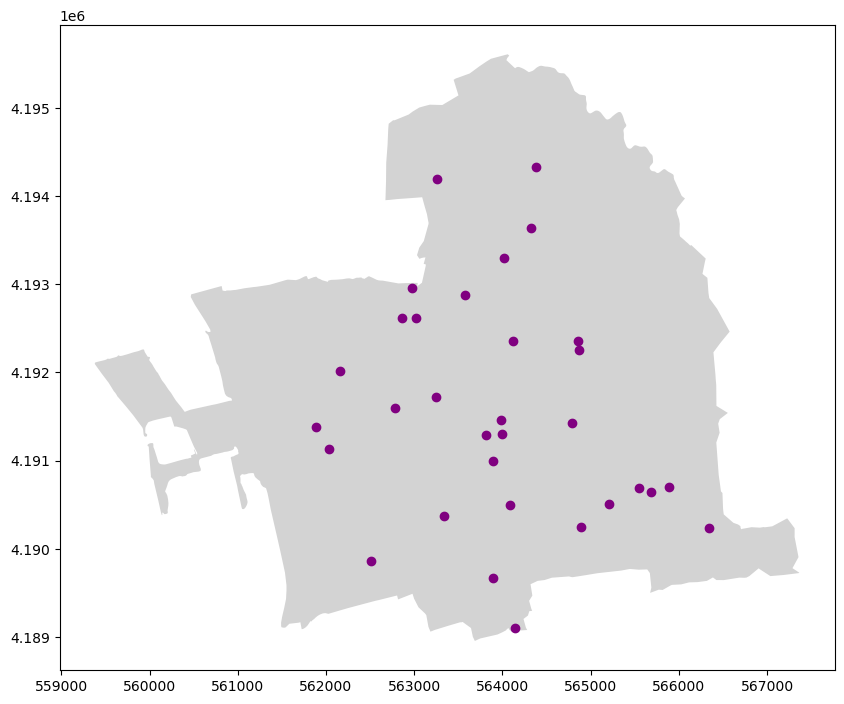

In [8]:
# Create a fig with one axis object
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the Berkeley border
berkeley_utm10.plot(color='lightgrey', ax=ax)
# Add the Berkeley schools
berkeley_schools.plot(color='purple', ax=ax)

---

### Challenge 2: Proximity Analysis

Now it's your turn to try out a proximity analysis!

Run the next cell to load BART-system data, reproject it to EPSG: 26910, and subset it to Berkeley.

Then in the following cell, write your own code to find all schools within walking distance (1 km) of a BART station.

As a reminder, let's break this into steps:

1. Buffer your Berkeley BART stations to 1 km (**HINT**: remember your units!).
2. Use the schools' `within` attribute to check whether or not they're within the buffers (**HINT**: don't forget the `unary_union`!).
3. Subset the Berkeley schools using the object returned by your spatial relationship query.
4. As always, plot your results for a good visual check!

---

In [9]:
# Load the BART stations from CSV
bart_stations = pd.read_csv('../data/transportation/bart.csv')
# Convert to a GeoDataFrame
bart_stations_gdf = gpd.GeoDataFrame(bart_stations, 
                                     geometry=gpd.points_from_xy(bart_stations.lon, bart_stations.lat))
# Define its unprojected (EPSG:4326) CRS
bart_stations_gdf.crs = "epsg:4326"
# Transform to UTM Zone 10 N (EPSG:26910)
bart_stations_gdf_utm10 = bart_stations_gdf.to_crs("epsg:26910")
# Subset to Berkeley
berkeley_bart = bart_stations_gdf_utm10[bart_stations_gdf_utm10.within(berkeley_utm10.unary_union)]

In [10]:
# Buffer the BART stations to 1 km
bart_buf = berkeley_bart.buffer(distance=1000)
# Check whether or not each school is within a buffer
schools_near_bart = berkeley_schools.within(bart_buf.unary_union)
bart_schools = berkeley_schools[schools_near_bart]

<AxesSubplot:>

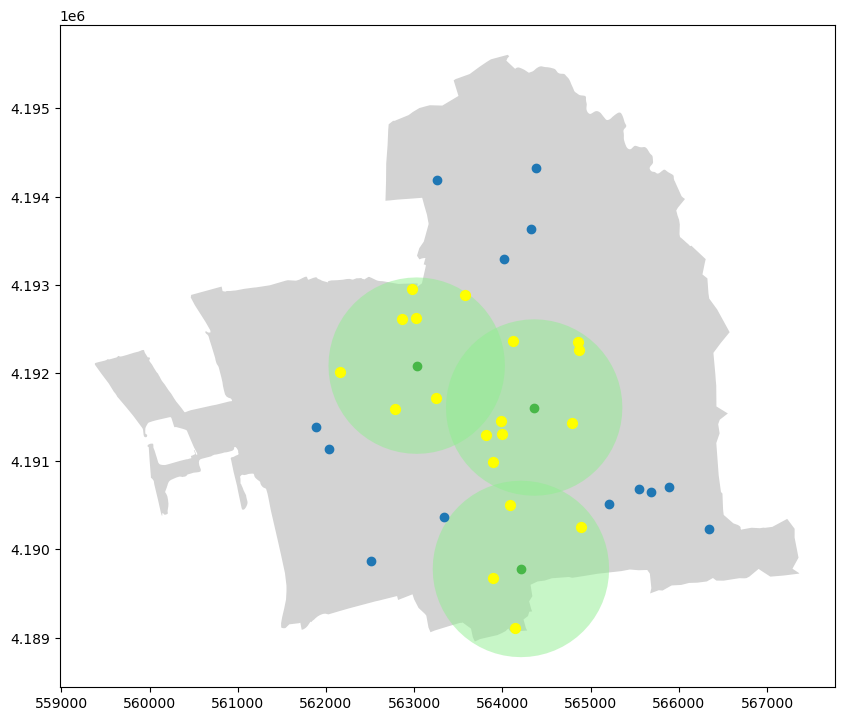

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the Berkeley boundary (for reference)
berkeley_utm10.plot(color='lightgrey', ax=ax)
# plot the BART stations (for reference)
berkeley_bart.plot(color='green', ax=ax)
# add the BART buffers (for check)
bart_buf.plot(color='lightgreen', ax=ax, alpha=0.5)
# add all Berkeley schools (for reference)
berkeley_schools.plot(ax=ax)
# add the schools near BART (for check)
bart_schools.plot(color='yellow', markersize=50, ax=ax)